https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [25]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 128
        
        self.conv = conv3x3(in_channels=3, out_channels=128)
        self.bn = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=128, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=256, blocks=layers[1], stride=2)
        # self.layer3 = self.make_layer(block=block, out_channels=512, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(4*4*256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [4, 3])

In [26]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
              ReLU-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]         147,456
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]         147,456
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
    ResidualBlock-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,456
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [27]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [28]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [29]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [30]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [31]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")


EPOCHS : 0


Batch_id=87 Batch Loss=1.709323763847351 Running Loss=246.59327018260956 Running Accuracy=26.03: 100%|██████████| 88/88 [02:50<00:00,  1.94s/it]



Validation set: Average loss: 0.0034, Accuracy: 1893/5000 (37.86%)


Test set: Average loss: 1.6967, Accuracy: 3900/10000 (39.00%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.5904067754745483 Running Loss=147.25039649009705 Running Accuracy=41.38: 100%|██████████| 88/88 [02:56<00:00,  2.00s/it]



Validation set: Average loss: 0.0028, Accuracy: 2434/5000 (48.68%)


Test set: Average loss: 1.4196, Accuracy: 4879/10000 (48.79%)

EPOCHS : 2


Batch_id=87 Batch Loss=1.4064764976501465 Running Loss=131.84409737586975 Running Accuracy=47.97: 100%|██████████| 88/88 [02:57<00:00,  2.02s/it]



Validation set: Average loss: 0.0027, Accuracy: 2518/5000 (50.36%)


Test set: Average loss: 1.3677, Accuracy: 5042/10000 (50.42%)

EPOCHS : 3


Batch_id=87 Batch Loss=1.170790433883667 Running Loss=121.2955619096756 Running Accuracy=52.22: 100%|██████████| 88/88 [02:57<00:00,  2.02s/it]



Validation set: Average loss: 0.0024, Accuracy: 2892/5000 (57.84%)


Test set: Average loss: 1.2359, Accuracy: 5768/10000 (57.68%)

EPOCHS : 4


Batch_id=87 Batch Loss=1.2300225496292114 Running Loss=107.314093708992 Running Accuracy=57.31: 100%|██████████| 88/88 [02:57<00:00,  2.01s/it]



Validation set: Average loss: 0.0023, Accuracy: 2993/5000 (59.86%)


Test set: Average loss: 1.2120, Accuracy: 5987/10000 (59.87%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.9663228392601013 Running Loss=98.90884083509445 Running Accuracy=60.82: 100%|██████████| 88/88 [02:57<00:00,  2.02s/it]



Validation set: Average loss: 0.0020, Accuracy: 3261/5000 (65.22%)


Test set: Average loss: 0.9926, Accuracy: 6549/10000 (65.49%)

EPOCHS : 6


Batch_id=87 Batch Loss=1.0033390522003174 Running Loss=90.57248067855835 Running Accuracy=64.25: 100%|██████████| 88/88 [02:58<00:00,  2.02s/it]



Validation set: Average loss: 0.0019, Accuracy: 3350/5000 (67.00%)


Test set: Average loss: 0.9992, Accuracy: 6542/10000 (65.42%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.9742749333381653 Running Loss=84.71654051542282 Running Accuracy=66.69: 100%|██████████| 88/88 [02:58<00:00,  2.03s/it]



Validation set: Average loss: 0.0018, Accuracy: 3471/5000 (69.42%)


Test set: Average loss: 0.9134, Accuracy: 6918/10000 (69.18%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.813854992389679 Running Loss=77.25336229801178 Running Accuracy=69.26: 100%|██████████| 88/88 [02:58<00:00,  2.03s/it]



Validation set: Average loss: 0.0016, Accuracy: 3581/5000 (71.62%)


Test set: Average loss: 0.8356, Accuracy: 7203/10000 (72.03%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.7377473711967468 Running Loss=71.50088912248611 Running Accuracy=71.59: 100%|██████████| 88/88 [02:57<00:00,  2.01s/it]



Validation set: Average loss: 0.0015, Accuracy: 3734/5000 (74.68%)


Test set: Average loss: 0.7329, Accuracy: 7498/10000 (74.98%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.6562855243682861 Running Loss=66.50246495008469 Running Accuracy=73.63: 100%|██████████| 88/88 [02:57<00:00,  2.02s/it]



Validation set: Average loss: 0.0014, Accuracy: 3765/5000 (75.30%)


Test set: Average loss: 0.7054, Accuracy: 7516/10000 (75.16%)

EPOCHS : 11


Batch_id=11 Batch Loss=0.6762485504150391 Running Loss=8.444615662097931 Running Accuracy=75.55:  14%|█▎        | 12/88 [00:26<02:48,  2.22s/it]


KeyboardInterrupt: ignored

In [ ]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3435, Accuracy: 9247/10000 (92.47%)


Test set: Average loss: 0.3428, Accuracy: 9252/10000 (92.52%)



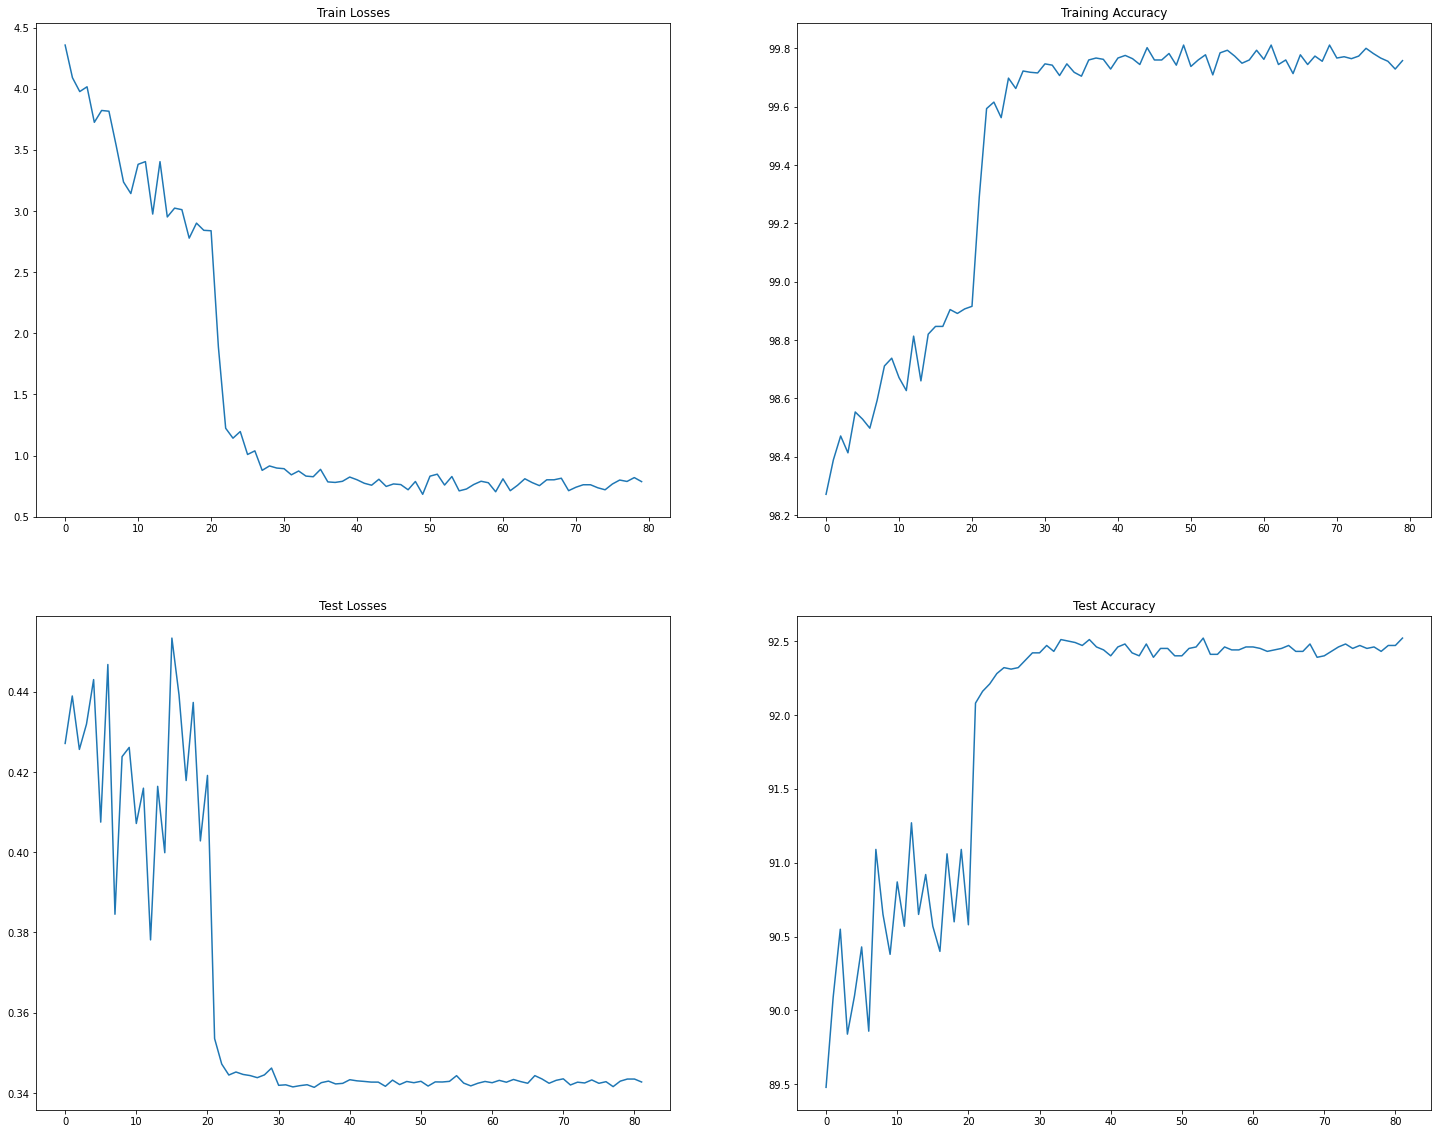

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)